# Relating the low-frequency wind influence on sea level to North Atlantic SST

Sea Surface temperatures are also obtained from two reanalysis data sets:


- HadISSTv1.1 https://www.metoffice.gov.uk/hadobs/hadisst/ 1870 - present


- COBE-SST2 https://psl.noaa.gov/data/gridded/data.cobe2.html 1850 - 2019

Both SST datasets have a spatial resolution of 1°x1°

**Warning** The code expects the names of the data files to be respectively HadISST_sst.nc and cobe_sst.mon.mean.nc


In [1]:
# Import packages
import copy
import regionmask

import numpy as np
import xarray as xr
import pandas as pd

import cartopy.crs as ccrs
import cartopy.feature as cf
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

import statsmodels.api as sm
import statsmodels.tsa.tsatools

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression as linr



In [2]:
path_sst = '../data/SST/'

fontsize = 15

### Import and process the wind data

In [3]:
wind_data = pd.read_csv('./outputs/Netherlands/WindInfluence.csv', index_col = 'time')
wind_data = wind_data[['NearestPointAverage2', 'PressureDifference']]

In [4]:
wind_data

,NearestPointAverage2,PressureDifference
time,,
1836,5.203631,-1.325051
1837,1.386855,-4.184167
1838,-0.247675,-5.592670
1839,1.201796,-5.709214
1840,4.382345,-2.750917
...,...,...
2018,2.034141,-2.438469
2019,5.109865,0.773454
2020,7.521410,3.488158


In [5]:
# Detrend the data using a third order polynomial
wind_data_dt = statsmodels.tsa.tsatools.detrend(wind_data, order=3, axis = 0)


In [6]:
# Apply a LOWESS function with a 21-year smoothing window

def df_smooth(df, window):
    
    lowess = sm.nonparametric.lowess
    
    df_lo = df.copy()
    
    frac = window/(df.index.size)
    
    for column in df:
        df_lo[column] = lowess(df[column].values, df.index.values, frac, return_sorted=False)
        
        
    return df_lo


wind_data_dt_sm = df_smooth(wind_data_dt, 21)



### Import and process the SST data

In [7]:
def xr_select_region(data, coords):
    '''
    Function that selects a given region of data for xarray dataset  
    
    Coords should have shape: [longitude minimum, longitude maximum, latitude minimum, latitude maximum].'''
    
    data = data.where(data.lon>=coords[0], drop=True)
    data = data.where(data.lon<=coords[1], drop=True)
    data = data.where(data.lat>=coords[2], drop=True)
    data = data.where(data.lat<=coords[3], drop=True)
    
    return data


def process_sst(data_type):
    '''
    Function to process the sst data.
    data_type is 'hadisst' or 'cobesst'.'''
    
    
    if data_type == 'hadisst':
        dataset = xr.open_dataset(path_sst + 'HadISST_sst.nc')
        
        # Remove sea ice values
        dataset = dataset.where(dataset.sst > -100)
        
        # Rename coordinates
        dataset = dataset.rename({'latitude': 'lat', 'longitude': 'lon'})
        
        
    elif data_type == 'cobesst':
        dataset = xr.open_dataset(path_sst + 'cobe_sst.mon.mean.nc')
        
        # Shift longitudes to -180-180
        dataset.coords['lon'] = (dataset.lon + 180) % 360 - 180

        
    else:
        print('Unknown data_type')
        
    
    # Obtain annual averages
    dataset = dataset.groupby('time.year').mean('time')
    
    # Rename coordinates
    dataset = dataset.rename({'year': 'time'})
        
    # Delete 2022
    dataset = dataset.where((dataset.time<2022), drop=True)

    # Sort dataarrays ascending
    dataset = dataset.sortby(dataset.lon, ascending=True)
    dataset = dataset.sortby(dataset.lat, ascending=True)

    # Select North Atlantic region
    dataset = xr_select_region(dataset, [-100, 10, 0, 90])


    # Save datasets
    dataset.sst.to_netcdf(f'{path_sst}{data_type}_processed.nc')


    return dataset

In [8]:
hadisst = process_sst('hadisst')
cobesst = process_sst('cobesst')

## Import and check datasets

In [9]:
hadisst = xr.open_dataset(path_sst + 'hadisst_processed.nc')
cobesst = xr.open_dataset(path_sst + 'cobesst_processed.nc')


In [10]:
# Detrend the data using a third order polynomial
hadisst_dt = hadisst.sst - xr.polyval(hadisst.time, hadisst.sst.polyfit(dim = 'time', deg = 3).polyfit_coefficients)
cobesst_dt = cobesst.sst - xr.polyval(cobesst.time, cobesst.sst.polyfit(dim = 'time', deg = 3).polyfit_coefficients)


# Apply a LOWESS function with a 21-year smoothing window

def da_smooth(da, window):
    '''
    Function to smooth a dataarray
    
    '''
    lowess = sm.nonparametric.lowess
    
    years = da.time.values
    frac = frac = window / da.time.size
    
    def lowess_1d(data):
        return lowess(data, years, frac, return_sorted = False)
    
    
    da_low = xr.apply_ufunc(lowess_1d, da, input_core_dims = [['time']], output_core_dims = [['time']], vectorize = True)
    
    return da_low

hadisst_dt_sm = da_smooth(hadisst_dt, 21)
cobesst_dt_sm = da_smooth(cobesst_dt, 21)


/Users/iriskeizer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/iriskeizer/opt/anaconda3/envs/py39/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Perform regression analysis

In [11]:
def regression(data_x, data_y):
    '''
    Data_x is sst and data_y is wind influence
    '''
    
    # Create dataframe
    x_l = pd.DataFrame(data={'time': data_x.time.values, 'SST':data_x.values})
    x_l = x_l.set_index('time')
    x_l = x_l.dropna()
    
    if x_l['SST'].size < 150 :
        return [np.nan, np.nan, np.nan, np.nan, np.nan], xr.DataArray(data=data_x.values ,dims=["time"], coords=dict(time=data_x.time.values,),) 
    # Return nan values if the array has decreased in size because of available nan values
    
    
    # Standardize x
    scaler = StandardScaler()
    x_l = copy.deepcopy(x_l)
    x_l.iloc[:,:] = scaler.fit_transform(x_l)
    
    
    
    # Create data series of equal time span
    y = data_y[data_y.index.isin(x_l.index)]
    x = x_l[x_l.index.isin(y.index)]
    
    
    # Fit the regression model
    linear_regression = linr()
    fit = linear_regression.fit(x, y)
    r2 = linear_regression.score(x, y)
    r = np.corrcoef(x['SST'].values, y.values)[0,1]
    intercept = linear_regression.intercept_
    coefs = linear_regression.coef_.tolist()[0]
    timeseries = coefs*x_l['SST']
    SST_reg_timeseries = xr.DataArray(data=timeseries.values ,dims=["time"], coords=dict(time=timeseries.index.values,),) 
        
    
    yhat = linear_regression.predict(x)
    mse = mean_squared_error(y, yhat) # Calculate insample mse (non-negative)
    rmse = np.sqrt(mse)
        
    
    return [rmse, r2, r, intercept, coefs], SST_reg_timeseries




def sst_regression(data_sst, data_wind):
    '''
    Function to perform the regression between the wind influence products and a SST product
    
    '''
    
    wind_labels = ['NearestPointAverage2', 'PressureDifference']
    
    ts_lst_wind = []
    res_lst_wind = []
    for wl in wind_labels:
      
        ts_lst_lat = []
        res_lst_lat = []
        for lat in data_sst.lat:
            
            ts_lst_lon = []
            rmse_lst = []
            r2_lst = []
            r_lst = []
            intercept_lst = []
            coefs_lst = []
            for lon in data_sst.lon:
                
                result, ts = regression(data_sst.sel(lat=lat, lon=lon, drop = True), data_wind[wl])
                
                ts_lst_lon.append(ts)
                rmse_lst.append(result[0])
                r2_lst.append(result[1])
                r_lst.append(result[2])
                intercept_lst.append(result[3])
                coefs_lst.append(result[4])
            
            
            ts_lst_lat.append(xr.concat(ts_lst_lon, dim=data_sst.lon))
            res_lst_lat.append(xr.Dataset(data_vars = dict(
                rmse = (['lon'], rmse_lst),
                r2 = (['lon'], r2_lst),
                r = (['lon'], r_lst),
                intercept = (['lon'], intercept_lst),
                reg_coef = (['lon'], coefs_lst)),
                                             coords = dict(lon=data_sst.lon)))
            
        ts_lst_wind.append(xr.concat(ts_lst_lat, dim=data_sst.lat))
        res_lst_wind.append(xr.concat(res_lst_lat, dim=data_sst.lat))  
        
    timeseries = xr.concat(ts_lst_wind, dim=wind_labels).rename({"concat_dim":"wind_model"})
    results = xr.concat(res_lst_wind, dim=wind_labels).rename({"concat_dim":"wind_model"})
    
    
    return results, timeseries

In [12]:
results_hadisst, timeseries_hadisst = sst_regression(hadisst_dt_sm, wind_data_dt_sm)
results_cobesst, timeseries_cobesst = sst_regression(cobesst_dt_sm, wind_data_dt_sm)

In [14]:
results_cobesst.to_netcdf('./outputs/cobe_sst.nc')

In [15]:
def regression_regions_fig(data_results, var, var_label, wind_model, title, ticks, cmap, extend, name):
    '''
    Function to make a plot of the three regions used for the lagged regression. '''
    
    amv = np.array([[-80, 0], [-80, 60], [0, 60], [0, 0]])
    north = np.array([[-40, 55], [-40, 65], [10, 65], [10, 55]])
    south = np.array([[-80, 10], [-80, 22], [-30, 22], [-30, 10]])


    
    plt.figure(figsize = (7,7))
    
    ax = plt.axes(projection=ccrs.Robinson(central_longitude=-45))
    ax.coastlines()
    plot = data_results[var].sel(wind_model = wind_model).plot(ax=ax, transform=ccrs.PlateCarree(), vmax = 0.7, cmap = cmap, 
                                                        add_colorbar=False)
    
    cb = plt.colorbar(plot, orientation="vertical", fraction = 0.035, ticks=ticks, extend=extend)                                   
    cb.set_label(label=var_label, size=fontsize+2)
    cb.ax.tick_params(labelsize=fontsize)                      
    
    ax.set_title(title, fontsize = fontsize)
    ax.add_feature(cf.LAND, color='silver', alpha = 0.25)
    #ax.add_feature(cf.OCEAN, color='silver', alpha = 0.5)
    ax.coastlines(resolution = '50m', linewidth=.7, color = 'k')
    ax.set_extent([-100, 10, 0, 80], crs=ccrs.PlateCarree())
    
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels = True)
    gl.top_labels = False
    gl.right_labels = False
    gl.xlabel_style = {'size': fontsize}
    gl.ylabel_style = {'size': fontsize}
    gl.ylocator = mticker.FixedLocator([20, 40, 60])
    gl.xlocator = mticker.FixedLocator([-80, -40, 0])
    
    text_kws = dict(bbox=dict(color="none"), fontsize=fontsize + 4, color = 'k')
    line_kws = dict(color = 'k', lw = 3)
    regionmask.Regions([amv], names=["AMV"]).plot(ax = ax, resolution="50m", 
                                                                                  projection=ccrs.Robinson(), 
                                                                                  label='name', 
                                                                                  line_kws=line_kws,
                                                                                  text_kws=text_kws)
    text_kws = dict(bbox=dict(color="none"), fontsize=fontsize + 4, color = 'white')
    line_kws = dict(color = 'white', lw = 3)
    regionmask.Regions([north, south], names=["North", "South"]).plot(ax = ax, resolution="50m", 
                                                                                  projection=ccrs.Robinson(), 
                                                                                  label='name', 
                                                                                  line_kws=line_kws,
                                                                                  text_kws=text_kws)
    
    
    
    


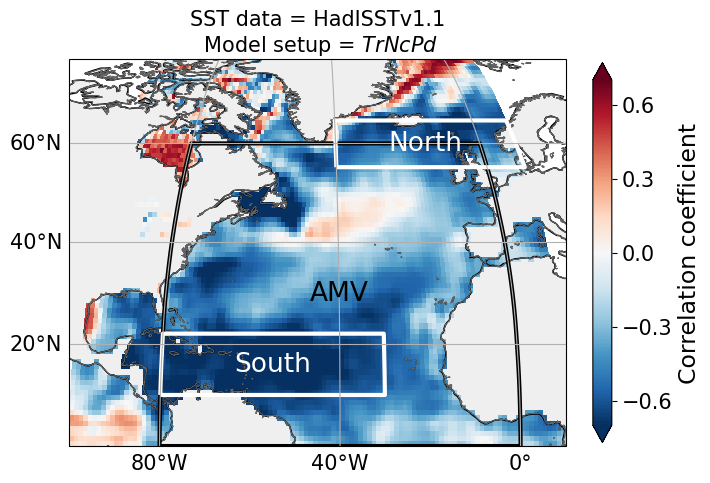

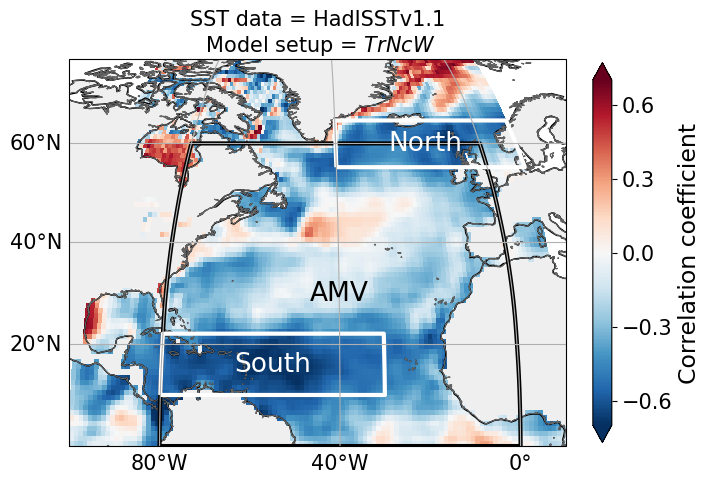

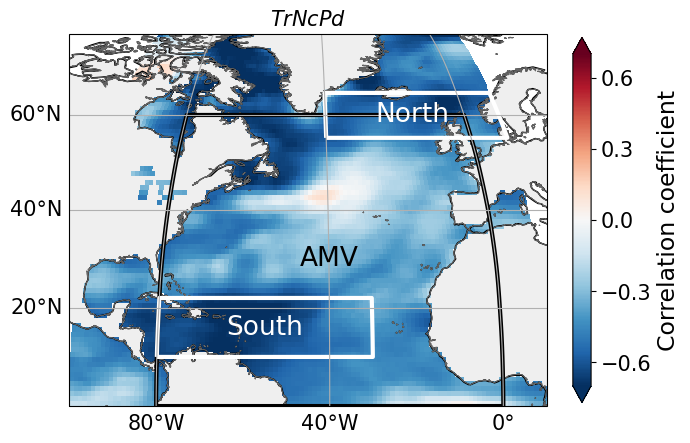

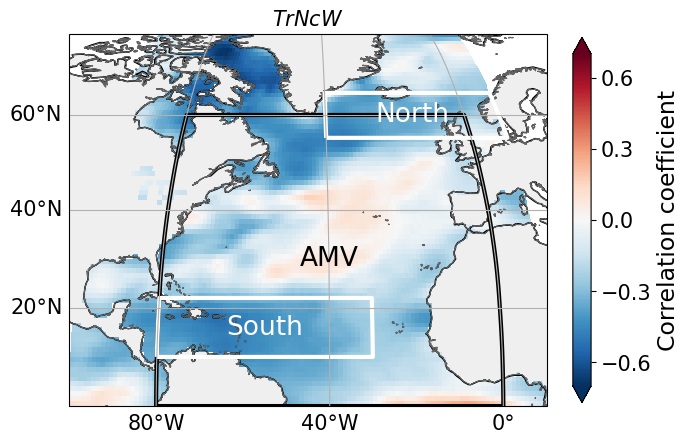

In [56]:
regression_regions_fig(results_hadisst, 'r', 'Correlation coefficient', 'PressureDifference', 'SST data = HadISSTv1.1\n Model setup = $\it{TrNcPd}$', 
                       [-0.6, -0.3, 0.0, 0.3, 0.6], 'RdBu_r', 'both', 'hadisst_r_PD')
regression_regions_fig(results_hadisst, 'r', 'Correlation coefficient', 'NearestPointAverage2', 'SST data = HadISSTv1.1\n Model setup = $\it{TrNcW}$', 
                       [-0.6, -0.3, 0.0, 0.3, 0.6], 'RdBu_r', 'both', 'hadisst_r_NP')
regression_regions_fig(results_cobesst, 'r', 'Correlation coefficient', 'PressureDifference', '$\it{TrNcPd}$', 
                       [-0.6, -0.3, 0.0, 0.3, 0.6], 'RdBu_r', 'both', 'cobesst_r_PD')
plt.tight_layout()
plt.savefig('./figures/cobe_correlation_sst_map_trncpd.pdf', dpi = 150)
regression_regions_fig(results_cobesst, 'r', 'Correlation coefficient', 'NearestPointAverage2', '$\it{TrNcW}$', 
                       [-0.6, -0.3, 0.0, 0.3, 0.6], 'RdBu_r', 'both', 'cobesst_r_NP')
plt.tight_layout()
plt.savefig('./figures/cobe_correlation_sst_map_trncw.pdf', dpi = 150)

## Perform lagged regression for different regions

In [17]:
def regression(data_x, data_y, lag):
    
    # Create dataframe
    x_l = pd.DataFrame(data={'time': data_x.index, 'AMV':data_x.values})
    x_l = x_l.set_index('time')
    
        
    # Standardize x
    scaler = StandardScaler()
    x_l = copy.deepcopy(x_l)
    x_l.iloc[:,:] = scaler.fit_transform(x_l)
    
    
    # Execute lagged regression by shifting the AMV dataframe. 
    x_l.index = x_l.index + lag
    
    
    # Create data series of equal time span
    y = data_y[data_y.index.isin(x_l.index)]
    x = x_l[x_l.index.isin(y.index)]
    
    
    # Fit the regression model
    linear_regression = linr()
    fit = linear_regression.fit(x, y)
    r2 = linear_regression.score(x, y)
    r = np.corrcoef(x['AMV'].values, y.values)[0,1]
    intercept = linear_regression.intercept_
    coefs = linear_regression.coef_.tolist()[0]
    AMV_reg_timeseries = coefs*x_l['AMV']
        
    yhat = linear_regression.predict(x)
    mse = mean_squared_error(y, yhat) # Calculate insample mse (non-negative)
    rmse = np.sqrt(mse)
        
    
    
    return [rmse, r2, r, intercept, coefs], AMV_reg_timeseries



def lagged_regression(data_x, data_y):
    
    lags = np.arange(-40, 41)
    
    ts_lst1 = []
    r_lst1 = []
    
    for column_x in data_x:
        ts_lst0 = []
        r_lst0 = []
        
        for column_y in data_y:
            df_timeseries = pd.DataFrame(columns = lags)
            df_results = df_timeseries.copy()
            df_timeseries['time'] = data_x.index
            df_timeseries = df_timeseries.set_index('time')
            
            df_results['result'] = ['rmse', 'r$^2$', 'r', 'constant', 'coef']
            df_results = df_results.set_index('result')
            
            for lag in lags:
                
                results, timeseries = regression(data_x[column_x], data_y[column_y], lag)
                df_timeseries[lag] = timeseries
                df_results[lag] = results
                
            ts_lst0.append(df_timeseries)
            r_lst0.append(df_results)
        
        ts_lst1.append(pd.concat(ts_lst0, axis=1, keys=data_y.columns))
        r_lst1.append(pd.concat(r_lst0, axis=1, keys=data_y.columns))
        
    timeseries = pd.concat(ts_lst1, axis=1, keys=data_x.columns)
    results = pd.concat(r_lst1, axis=1, keys=data_x.columns)

    return results, timeseries



### Lagged regression over AMV region

In [18]:
# Take weighted average over region 0°N to 60°N and 80°W to 0°E
hadisst_amv = hadisst.where((hadisst.lat < 60 ) & (hadisst.lon > -80) & (hadisst.lon < 0), drop = True)
cobesst_amv = cobesst.where((cobesst.lat < 60 ) & (cobesst.lon > -80) & (cobesst.lon < 0), drop = True)

weights_amv = np.cos(np.deg2rad(hadisst_amv.lat))

hadisst_amv_weighted =  hadisst_amv.weighted(weights_amv)
cobesst_amv_weighted =  cobesst_amv.weighted(weights_amv)

hadisst_amv = hadisst_amv_weighted.mean(dim = ['lat', 'lon'])
cobesst_amv = cobesst_amv_weighted.mean(dim = ['lat', 'lon'])


# Select data from 1870 till 2019
hadisst_amv = hadisst_amv.where(hadisst_amv.time <= 2019, drop = True)
cobesst_amv = cobesst_amv.where(cobesst_amv.time >= 1870, drop = True)


# Create dataframe
AMV_data = pd.DataFrame({'HadISSTv1.1' : hadisst_amv.sst, 'COBE-SST2' : cobesst_amv.sst}, index = cobesst_amv.time)

In [19]:
# Detrend the data using a third order polynomial
AMV_data_dt = statsmodels.tsa.tsatools.detrend(AMV_data, order=3, axis = 0)


(1830.0, 2030.0)

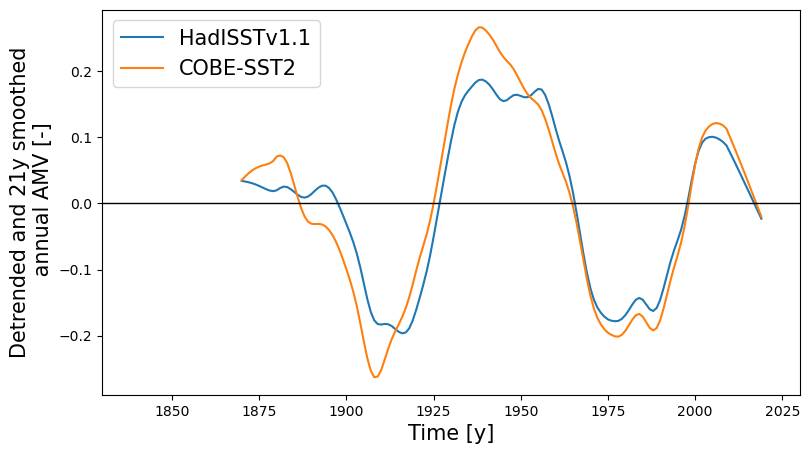

In [20]:
# Apply a LOWESS function with a 21-year smoothing window

AMV_data_dt_sm = df_smooth(AMV_data_dt, 21)

AMV_data_dt_sm.plot(figsize = (9,5))
plt.legend(fontsize = fontsize, loc = 'upper left')
plt.xlabel('Time [y]', fontsize = fontsize)
plt.ylabel('Detrended and 21y smoothed\n annual AMV [-]', fontsize = fontsize)
plt.axhline(color='k', linewidth = 1)  
plt.xlim(1830,2030)


In [21]:
results_amv, timeseries_amv = lagged_regression(AMV_data_dt_sm, wind_data_dt_sm)

### Lagged regression over NORTH region

In [22]:
# Take weighted average over region 0°N to 60°N and 80°W to 0°E
hadisst_amv = hadisst.where((hadisst.lat < 60 ) & (hadisst.lon > -80) & (hadisst.lon < 0), drop = True)
cobesst_amv = cobesst.where((cobesst.lat < 60 ) & (cobesst.lon > -80) & (cobesst.lon < 0), drop = True)

weights_amv = np.cos(np.deg2rad(hadisst_amv.lat))

hadisst_amv_weighted =  hadisst_amv.weighted(weights_amv)
cobesst_amv_weighted =  cobesst_amv.weighted(weights_amv)

hadisst_amv = hadisst_amv_weighted.mean(dim = ['lat', 'lon'])
cobesst_amv = cobesst_amv_weighted.mean(dim = ['lat', 'lon'])


# Select data from 1870 till 2019
hadisst_amv = hadisst_amv.where(hadisst_amv.time <= 2019, drop = True)
cobesst_amv = cobesst_amv.where(cobesst_amv.time >= 1870, drop = True)


# Create dataframe
AMV_data = pd.DataFrame({'HadISSTv1.1' : hadisst_amv.sst, 'COBE-SST2' : cobesst_amv.sst}, index = cobesst_amv.time)

In [23]:
# Detrend the data using a third order polynomial
AMV_data_dt = statsmodels.tsa.tsatools.detrend(AMV_data, order=3, axis = 0)


(1830.0, 2030.0)

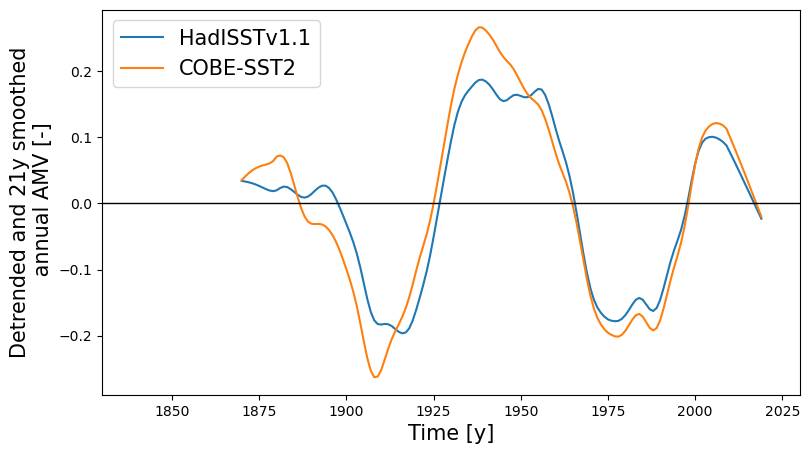

In [24]:
# Apply a LOWESS function with a 21-year smoothing window

AMV_data_dt_sm = df_smooth(AMV_data_dt, 21)

AMV_data_dt_sm.plot(figsize = (9,5))
plt.legend(fontsize = fontsize, loc = 'upper left')
plt.xlabel('Time [y]', fontsize = fontsize)
plt.ylabel('Detrended and 21y smoothed\n annual AMV [-]', fontsize = fontsize)
plt.axhline(color='k', linewidth = 1)  
plt.xlim(1830,2030)


In [25]:
results_amv, timeseries_amv = lagged_regression(AMV_data_dt_sm, wind_data_dt_sm)

### Lagged regression over NORTH region

In [26]:
# Take weighted average over Northern region 55°N to 65°N and 40°W to 10°E 

hadisst_north = hadisst.where((hadisst.lat > 55 ) & (hadisst.lat < 65 ) & (hadisst.lon > -40) & (hadisst.lon < 10), drop = True)
cobesst_north = cobesst.where((cobesst.lat > 55 ) & (cobesst.lat < 65 ) & (cobesst.lon > -40) & (cobesst.lon < 10), drop = True)

weights_north = np.cos(np.deg2rad(hadisst_north.lat))

hadisst_north_weighted =  hadisst_north.weighted(weights_north)
cobesst_north_weighted =  cobesst_north.weighted(weights_north)

hadisst_north = hadisst_north_weighted.mean(dim = ['lat', 'lon'])
cobesst_north = cobesst_north_weighted.mean(dim = ['lat', 'lon'])

# Select data from 1870 till 2019
hadisst_north = hadisst_north.where(hadisst_north.time <= 2019, drop = True)
cobesst_north = cobesst_north.where(cobesst_north.time >= 1870, drop = True)


# Create dataframe
NORTH_data = pd.DataFrame({'HadISSTv1.1' : hadisst_north.sst, 'COBE-SST2' : cobesst_north.sst}, index = cobesst_north.time)

In [27]:
# Detrend the data using a third order polynomial
NORTH_data_dt = statsmodels.tsa.tsatools.detrend(NORTH_data, order=3, axis = 0)



(1830.0, 2030.0)

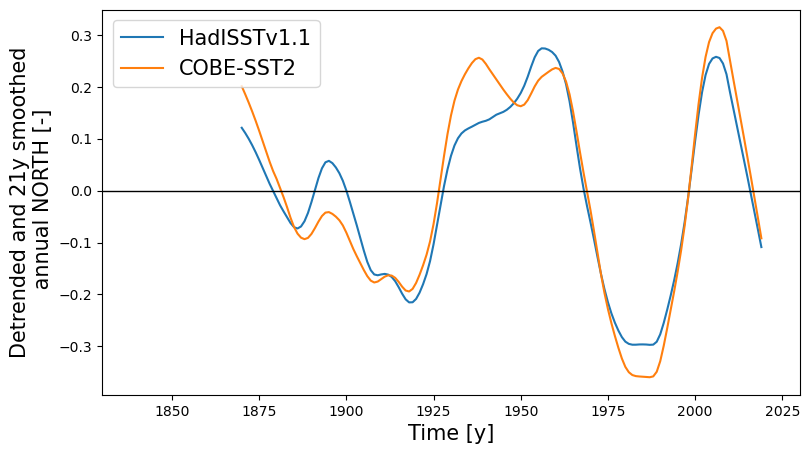

In [28]:
# Apply a LOWESS function with a 21-year smoothing window

NORTH_data_dt_sm = df_smooth(NORTH_data_dt, 21)

NORTH_data_dt_sm.plot(figsize = (9,5))
plt.legend(fontsize = fontsize, loc = 'upper left')
plt.xlabel('Time [y]', fontsize = fontsize)
plt.ylabel('Detrended and 21y smoothed\n annual NORTH [-]', fontsize = fontsize)
plt.axhline(color='k', linewidth = 1)  
plt.xlim(1830,2030)


In [29]:
results_north, timeseries_north = lagged_regression(NORTH_data_dt_sm, wind_data_dt_sm)

### Lagged regression over SOUTH region

In [30]:
# Take weighted average over Northern region 55°N to 65°N and 40°W to 10°E 

hadisst_south = hadisst.where((hadisst.lat > 10 ) & (hadisst.lat < 22 ) & (hadisst.lon > -80) & (hadisst.lon < -30), drop = True)
cobesst_south = cobesst.where((cobesst.lat > 10 ) & (cobesst.lat < 22 ) & (cobesst.lon > -80) & (cobesst.lon < -30), drop = True)

weights_south = np.cos(np.deg2rad(hadisst_south.lat))

hadisst_south_weighted =  hadisst_south.weighted(weights_south)
cobesst_south_weighted =  cobesst_south.weighted(weights_south)

hadisst_south = hadisst_south_weighted.mean(dim = ['lat', 'lon'])
cobesst_south = cobesst_south_weighted.mean(dim = ['lat', 'lon'])

# Select data from 1870 till 2019
hadisst_south = hadisst_south.where(hadisst_south.time <= 2019, drop = True)
cobesst_south = cobesst_south.where(cobesst_south.time >= 1870, drop = True)


# Create dataframe
SOUTH_data = pd.DataFrame({'HadISSTv1.1' : hadisst_south.sst, 'COBE-SST2' : cobesst_south.sst}, index = cobesst_south.time)

In [31]:
# Detrend the data using a third order polynomial
SOUTH_data_dt = statsmodels.tsa.tsatools.detrend(SOUTH_data, order=3, axis = 0)


(1830.0, 2030.0)

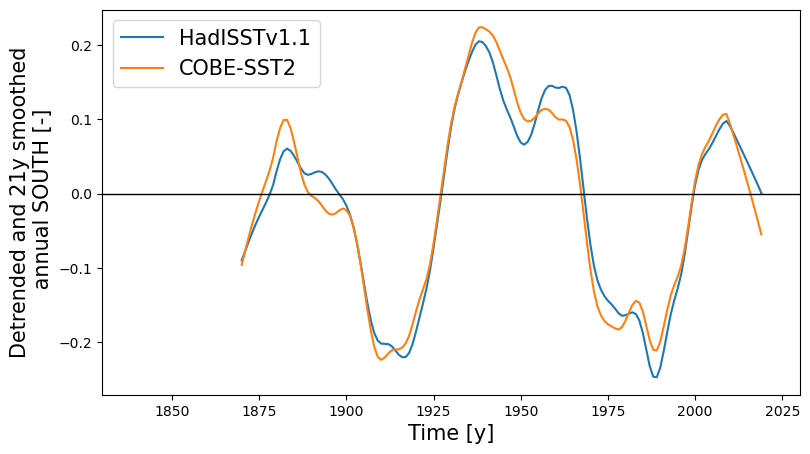

In [32]:
# Apply a LOWESS function with a 21-year smoothing window

SOUTH_data_dt_sm = df_smooth(SOUTH_data_dt, 21)

SOUTH_data_dt_sm.plot(figsize = (9,5))
plt.legend(fontsize = fontsize, loc = 'upper left')
plt.xlabel('Time [y]', fontsize = fontsize)
plt.ylabel('Detrended and 21y smoothed\n annual SOUTH [-]', fontsize = fontsize)
plt.axhline(color='k', linewidth = 1)  
plt.xlim(1830,2030)


In [33]:
results_south, timeseries_south = lagged_regression(SOUTH_data_dt_sm, wind_data_dt_sm)

## Compare results of different regions

In [53]:
def compare_reg_res_fig_cobe(var, var_label, ymin = 0.0, ymax = 0.8):
    '''
    Function that plots a figure to compare the results of the regression for the different regions.'''
    
    labels_wind = ['NearestPointAverage2', 'PressureDifference']
    labels_AMV = ['HadISSTv1.1', 'COBE-SST2']
    colors = ['tab:red', 'tab:orange', 'tab:blue']
    
    s = 20
    
    fig, axs = plt.subplots(2, 1, figsize = (7,8))

    for i, l in enumerate(labels_wind):


        ax = axs[i]

        data_amv = results_amv.swaplevel(0,1, axis=1)[l]
        data_north = results_north.swaplevel(0,1, axis=1)[l]
        data_south = results_south.swaplevel(0,1, axis=1)[l]

        dataT_amv = data_amv[labels_AMV[1]].T
        dataT_north = data_north[labels_AMV[1]].T
        dataT_south = data_south[labels_AMV[1]].T

        ax.scatter(dataT_amv.index, dataT_amv[var].values, s = s, color = colors[0])
        ax.scatter(dataT_north.index, dataT_north[var].values, s = s, color = colors[1])
        ax.scatter(dataT_south.index, dataT_south[var].values, s = s, color = colors[2])
        ax.grid() 
        
        error_amv = (1-dataT_amv[var].values**2 ) / (np.sqrt(dataT_amv[var].size-2))
        error_north = (1-dataT_north[var].values**2 ) / (np.sqrt(dataT_north[var].size-2))
        error_south = (1-dataT_south[var].values**2 ) / (np.sqrt(dataT_south[var].size-2))
        
        ax.fill_between(dataT_amv.index.astype('float'), dataT_amv[var].values.astype('float') - error_amv, dataT_amv[var].values.astype('float') + error_amv, alpha = 0.2, color = colors[0])
        ax.fill_between(dataT_north.index.astype('float'), dataT_north[var].values.astype('float') - error_north, dataT_north[var].values.astype('float') + error_north, alpha = 0.2, color = colors[1])
        ax.fill_between(dataT_south.index.astype('float'), dataT_south[var].values.astype('float') - error_south, dataT_south[var].values.astype('float') + error_south, alpha = 0.2, color = colors[2])
        
        ax.set_ylabel(f'{var_label}', fontsize=17)   
        ax.set_xticks([-40, -20, 0, 20, 40])
        ax.set_yticks([-0.8, -0.4, 0.0, 0.4, 0.8])
        ax.tick_params(axis='both', which='major', labelsize=15)
        
        
        if i == 1:
            ax.set_xlabel('Lag [years]', fontsize=17)
            ax.legend(labels = ['AMV', 'North', 'South'],loc = 'lower left', fontsize =  15)
            
        setups = ['$\it{TrNcW}$', '$\it{TrNcPd}$']
        ax.set_title(f'\n{setups[i]}', fontsize=15)
            
        ax.set_ylim(ymin, ymax) 
        

    plt.tight_layout()
    plt.savefig('./figures/cobe_lagged_correlation_sst.pdf', dpi = 150)



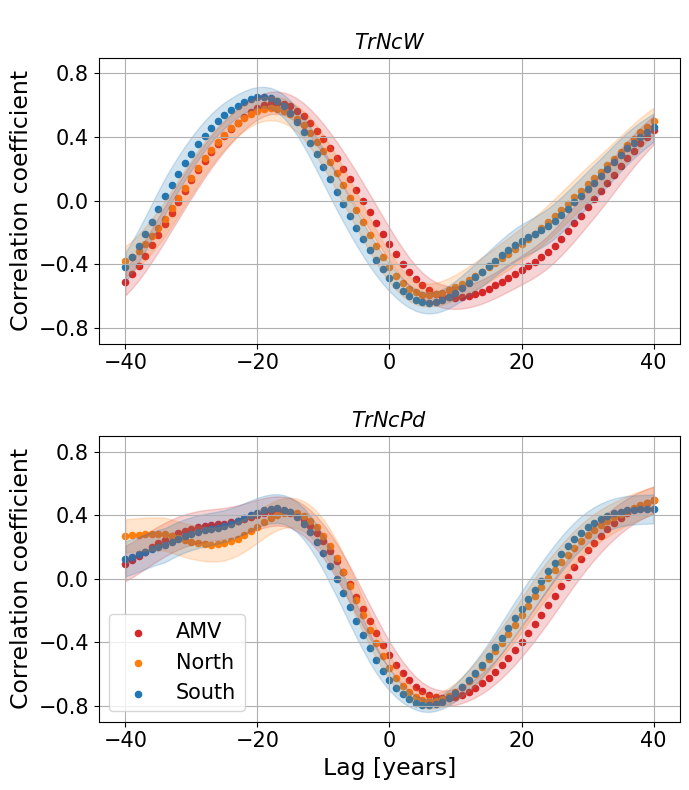

In [54]:
compare_reg_res_fig_cobe('r', 'Correlation coefficient', ymin = -0.9, ymax = 0.9)
